In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from six.moves import xrange
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import wtte.weibull as weibull
from wtte.wtte import loglik_discrete

# Basics : Weibull distribution

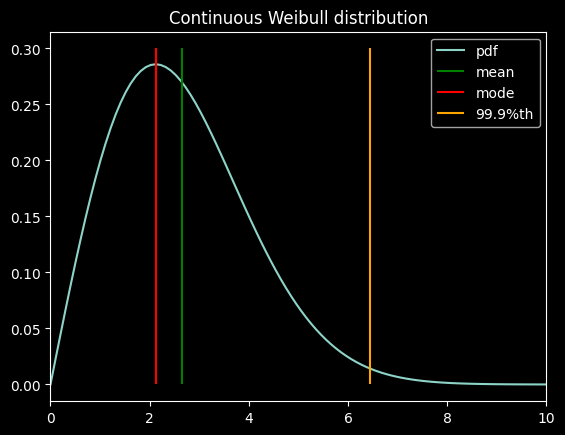

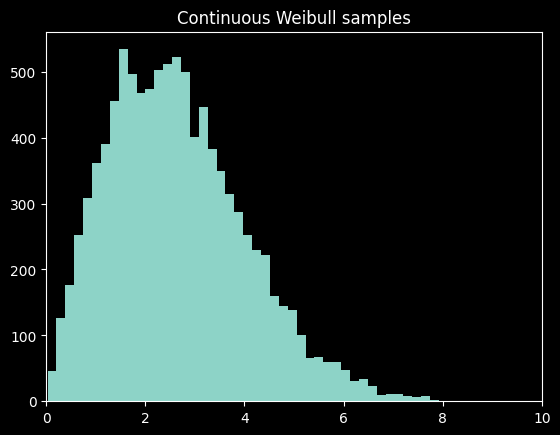

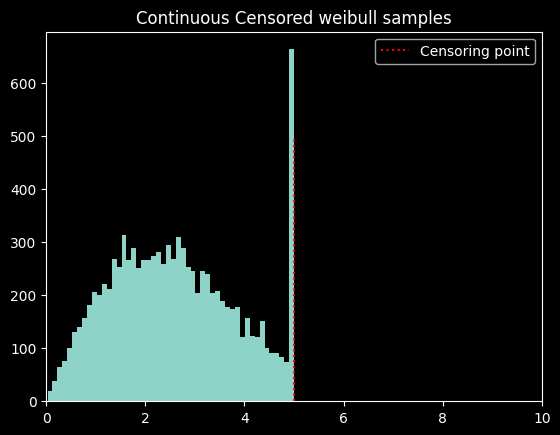

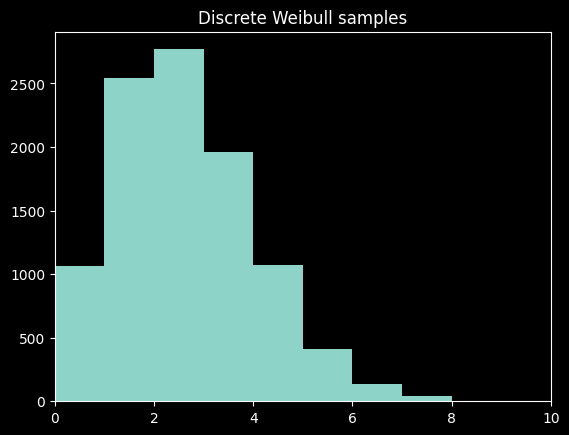

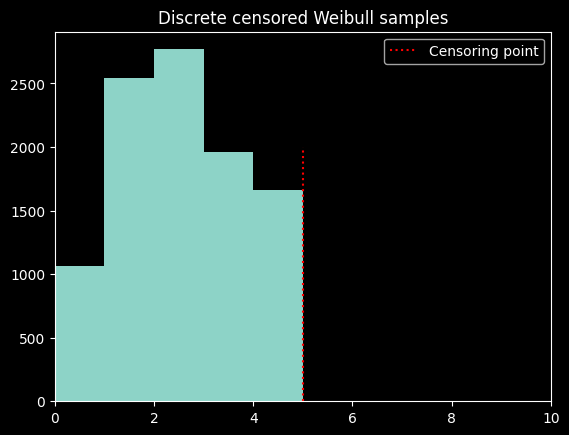

In [3]:
np.random.seed(1)

alpha = 3.
beta  = 2.
# Weibull is a simple distribution. 
y = np.linspace(0, 10, 100)
# pdf  : (b / a) * np.power(t / a, b - 1) * np.exp(-np.power(t / a, b))
plt.plot(y, weibull.pdf(t=y, a=alpha, b=beta), label='pdf')
# And all the nice 
plt.vlines(x=weibull.mean(a=alpha, b=beta), ymin=0, ymax=.3, color='green', label = 'mean')
plt.vlines(x=weibull.mode(a=alpha, b=beta), ymin=0, ymax=.3, color='red', label = 'mode')
plt.vlines(x=weibull.quantiles(a=alpha, b=beta, p=0.99), ymin=0, ymax=.3, color='orange', label = '99.9%th')
plt.legend()
plt.xlim(0, y.max())
plt.title('Continuous Weibull distribution')
plt.show()

# If we know the params alpha and beta we can easily generate data from it
# quantiles : a * np.power(-np.log(1.0 - p), 1.0 / b)
weibull_samples = weibull.quantiles(a=alpha, b=beta,
                                    p=np.random.uniform(0, 1, 10000))

plt.hist(weibull_samples,50)
plt.xlim(0,y.max())
plt.title('Continuous Weibull samples')
plt.show()

# We can simulate censored data by simply truncating it
censoring_point = 5.
weibull_samples_censored = np.minimum(weibull_samples, censoring_point)

plt.hist(weibull_samples_censored,50)
plt.vlines(x=censoring_point, ymin=0, ymax=500, color='red',
           linestyles='dotted', label='Censoring point')
plt.legend()
plt.title('Continuous Censored weibull samples')
plt.xlim(0, y.max())
plt.show()

# And it's even simpler to create discrete data:
weibull_samples_discrete = np.floor(weibull_samples)

plt.hist(weibull_samples_discrete, bins=list(set(weibull_samples_discrete)))
plt.xlim(0, y.max())
plt.title('Discrete Weibull samples')
plt.show()

# Create some discrete censored data for estimation
u = np.less_equal(weibull_samples_discrete, censoring_point)
weibull_samples_discrete_censored = weibull_samples_discrete
weibull_samples_discrete_censored[~u] = censoring_point

plt.hist(weibull_samples_discrete_censored,bins = list(set(weibull_samples_discrete_censored)))
plt.vlines(x=censoring_point, ymin=0, ymax=2000, color='red',
           linestyles='dotted', label='Censoring point')
plt.legend()
plt.xlim(0, y.max())
plt.title('Discrete censored Weibull samples')
plt.show()

## Estimation - tensorflow

From here we'll focus on the discrete distribution (since continous data are less frequent in the wild).

In [12]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# Launch the graph in a session.
np.random.seed(1)
tf.random.set_seed(1)

y_ = tf.constant(weibull_samples_discrete_censored, dtype=tf.float32)
u_ = tf.constant(u*1., dtype=tf.float32)

a = tf.Variable(0.5*tf.ones([1]), name='a_weight')
b = tf.Variable(0.5*tf.ones([1]), name='b_weight')
a = tf.exp(a)
b = tf.exp(b)

loglik = loglik_discrete(a, b, y_, u_)
#hazard0 = tf.pow(tf.divide(y_ + 1e-35, a), b)
#hazard1 = tf.pow(tf.divide(y_ + 1.0, a), b)
#loglik = tf.multiply(u_, tf.math.log(tf.exp(hazard1 - hazard0) - 1.0)) - hazard1
loss = -tf.reduce_mean(loglik)
optimizer = tf.optimizers.SGD(learning_rate=0.01).minimize(loss, var_list=[a,b])

for step in range(1001):
    with tf.GradientTape() as tape:
        loss_val = loss
    grads = tape.gradient(loss_val, [a, b])
    optimizer.apply_gradients(zip(grads, [a, b]))
    if step % 100 == 0:
        print("step=%d, loss=%.4f, a=%.4f, b=%.4f" % (step, loss_val, a.numpy(), b.numpy()))
print('actual | alpha :', alpha, ' beta :', beta)
# Should converge to the approximate value that we generated
# Higher alpha leads to higher accuracy.

ValueError: `tape` is required when a `Tensor` loss is passed. Received: loss=Tensor("Neg_2:0", shape=(), dtype=float32), tape=None.

#### Hint : here $\alpha$ and $\beta$ are just scalars but they might as well be a neural network layer. That's the simple WTTE-RNN trick
